# Predicting whether someone is an asshole, based on their Submission 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
# using fast ai for prediction task 
import fastai
from fastai.text import *
import pickle

## Loading the Data 

In [3]:
# load the dict 
def load_obj(name):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

aita_dict = load_obj('aita_dict')

# import as dataframe 
aita_data = pd.DataFrame(aita_dict)

In [4]:
aita_data.head()

,title,body,id,url,flair
0,AITA for changing my mind midway through buyin...,I stopped by a local coffee place after work t...,b8sdv1,https://www.reddit.com/r/AmItheAsshole/comment...,Not the A-hole
1,WIBTA If I told my 16yo deaf sister that she m...,Me and my pregnant wife have moved back in wit...,b8ydqz,https://www.reddit.com/r/AmItheAsshole/comment...,None
2,AITA for yelling at my aunt for telling my fam...,I've been in therapy for a few months now for ...,b8xuwn,https://www.reddit.com/r/AmItheAsshole/comment...,None
3,AITA for calling out my transgender friend aft...,"I am ethnically Chinese, born and raised in Br...",b8rwmf,https://www.reddit.com/r/AmItheAsshole/comment...,Not the A-hole
4,AITA for wearing a black dress to a wedding?,I am a 21F college student currently living on...,b8tqhx,https://www.reddit.com/r/AmItheAsshole/comment...,None


In [5]:
print(aita_data.isnull().values.sum())
print(aita_data['flair'].unique())

511
['Not the A-hole' None 'Asshole' 'No A-holes here' ... 'auto-asshole' 'meta-asshole' 'Shit post' 'the usual shitpost']


In [6]:
print(aita_data['flair'].value_counts())

Not the A-hole                2746
Asshole                       1760
No A-holes here                667
Everyone Sucks                 366
Not enough info                111
not the a-hole                 110
asshole                        104
Shitpost                        51
META                            39
                                38
everyone sucks                  16
TL;DR                            8
UPDATE                           8
Probably Fake                    8
shitpost                         7
Update                           7
not the asshole                  6
Shit Post                        5
not enough info                  4
too close to call                4
Validate me!                     3
Troll                            2
probably fake                    2
the usual shitpost               1
troll                            1
Validation Post | Locked         1
update                           1
asshole, but funny               1
NTA / YTA           

## Preprocessing the Data 

In [7]:
# some preprocessing 
#-------------------------------------------------------------------------------------------------------
include = ['Not the A-hole', 'Asshole']

# not the a-hole and No A-holes here => Not the A-hole 
aita_data['flair'] = aita_data['flair'].replace(['not the a-hole', 'No A-holes here'], 'Not the A-hole')

# asshole => Asshole 
aita_data['flair'] = aita_data['flair'].replace('asshole', 'Asshole')

# delete all other cases 
aita_data = aita_data[aita_data['flair'].isin(include)]

# delete NaN cases 
aita_data = aita_data.dropna() 


In [8]:
print(aita_data['flair'].value_counts())

Not the A-hole    3523
Asshole           1864
Name: flair, dtype: int64


In [9]:
# make 80/20 random split 
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(aita_data[['title','body']], aita_data['flair'], test_size=0.1, random_state=42)

train_df = pd.concat([X_train,y_train],axis=1, sort=False)
valid_df = pd.concat([X_test,y_test],axis=1, sort=False)


In [10]:
# check if everything is ready for the language model 
print(train_df.isnull().values.sum() == 0)
print(valid_df.isnull().values.sum() == 0)

True
True


## Language Model 

In [11]:
bs = 16
path = '…/'

In [12]:
# create/ fine tune a language model 
data_lm = TextLMDataBunch.from_df(path, 
                                train_df = pd.concat([y_train,X_train],axis=1, sort=False), 
                                valid_df = pd.concat([y_test,X_test],axis=1, sort=False), 
                                label_cols = 'flair',
                                text_cols = ['title','body'],
                                bs = bs
                                )

In [13]:
data_lm

TextLMDataBunch;

Train: LabelList
y: LMLabel (4848 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: …
x: LMTextList (4848 items)
[Text xxbos xxup wibta for asking my gay little brother not to bring home guys to the apartment while he is living with me ? “ xxmaj ryan ” is 15 and came out to our homophobic parents about four months ago . xxmaj they promptly kicked him out of the house and he had to come live with me . i ’ve also lost contact with my parents because of this . 

 xxmaj for the most part living with him has been fine . xxmaj he picks up after himself ( mostly ) and still goes to school and works to help me out with bills . 

 xxmaj one thing however , is that lately he has been seeing this boy and bringing him over to the apartment to have sex ( i have a spare bedroom ) . 

 i do n’t care if he ’s having sex or who it ’s with , and i mean i really could not care less i ca n’t emphasize that enough , but it is making me so uncomfortable in my own

In [24]:
# save as pkl
data_lm.save()

In [25]:
#data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [26]:
data_lm.show_batch()

idx,text
0,"this . \n\n xxmaj for the most part living with him has been fine . xxmaj he picks up after himself ( mostly ) and still goes to school and works to help me out with bills . \n\n xxmaj one thing however , is that lately he has been seeing this boy and bringing him over to the apartment to have sex ( i have a spare bedroom )"
1,". xxmaj it truly helps me to be less defensive about the situation . xxmaj she is coming home and we decided that during this stressful time in our lives ( xxmaj buying a house , about to be married , moving in with my dad in between renting and buying , full time job with school , etc ) we will both be more forgiving and try to take"
2,i feel like i should clear this up since it keeps coming up . xxmaj my daughter has never asked for my inlaws not to come . xxmaj this is the first year she has nt even had the hope for a good party which is why this is the first year i 'm considering not inviting them . i 'm sure if i asked her flat out of she
3,"\n\n i ended up going out on a xxmaj friday , which is n’t normal for me because of how busy i am . i was out with a friend of mine and i met a different guy , super funny and very cute . xxmaj suddenly , i feel someone grab my shoulder and it ’s the first guy . xxmaj he leans over and says something like “"
4,"costs about $ 30 but since we were short on time we gave them the extra $ 70 for the trouble of getting more . \n\n\n xxmaj we made sure to let them know all the proper care instructions such as when and how much to feed them , when to take them out , how much exercise they need etc . and they assured us they were okay with"


In [27]:
data_lm.train_ds.x[0]

Text xxbos xxup wibta for asking my gay little brother not to bring home guys to the apartment while he is living with me ? “ xxmaj ryan ” is 15 and came out to our homophobic parents about four months ago . xxmaj they promptly kicked him out of the house and he had to come live with me . i ’ve also lost contact with my parents because of this . 

 xxmaj for the most part living with him has been fine . xxmaj he picks up after himself ( mostly ) and still goes to school and works to help me out with bills . 

 xxmaj one thing however , is that lately he has been seeing this boy and bringing him over to the apartment to have sex ( i have a spare bedroom ) . 

 i do n’t care if he ’s having sex or who it ’s with , and i mean i really could not care less i ca n’t emphasize that enough , but it is making me so uncomfortable in my own place . i can hear them at night , and when i get home . i ’m losing sleep because it makes me so awkward and uncomfortable . i feel like i ’m losing my mind 

In [24]:
len(data_lm.train_ds.x)

4848

In [25]:
# Transformer worked better than AWD-LSTM on more data (>1000 observations)
learn = language_model_learner(data_lm, "AWD_LSTM" ,pretrained_model=URLs.WT103, drop_mult=0.3)

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


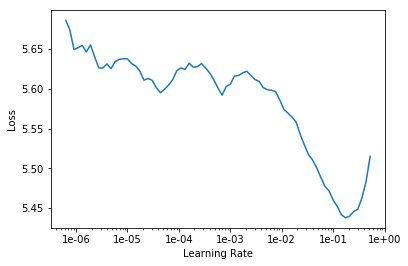

In [27]:
learn.recorder.plot(skip_end=15)

In [28]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.037700,3.860387,0.261558


In [29]:
learn.save('fit')

In [30]:
learn.load('fit');

In [31]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.806899,3.745051,0.273826
2,3.715688,3.658650,0.284710
3,3.622281,3.607084,0.291719
4,3.514736,3.578971,0.295219
5,3.395329,3.568634,0.297661
6,3.297597,3.567859,0.298321
7,3.200011,3.576828,0.298821
8,3.061320,3.592862,0.297964
9,2.999361,3.605191,0.297625
10,2.939316,3.611665,0.297312


In [32]:
learn.save('fine_tuned')

In [33]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (4848 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: …
x: LMTextList (4848 items)
[Text xxbos xxup wibta for asking my gay little brother not to bring home guys to the apartment while he is living with me ? “ xxmaj ryan ” is 15 and came out to our homophobic parents about four months ago . xxmaj they promptly kicked him out of the house and he had to come live with me . i ’ve also lost contact with my parents because of this . 

 xxmaj for the most part living with him has been fine . xxmaj he picks up after himself ( mostly ) and still goes to school and works to help me out with bills . 

 xxmaj one thing however , is that lately he has been seeing this boy and bringing him over to the apartment to have sex ( i have a spare bedroom ) . 

 i do n’t care if he ’s having sex or who it ’s with , and i mean i really could not care less i ca n’t emphasize that enough , but it is making me so un

In [34]:
learn.predict('Yesterday I met with my brothers girlfriend and ', 300, temperature=1.1, min_p=0.001)

'Yesterday I met with my brothers girlfriend and  let her keep playing the kid . xxmaj our agreed terms were just the same as the usual . xxmaj now my husband has brought this up about that and said i should feel comfortable with him getting back in his life and would really want me to do something . \n\n xxmaj during work for xxmaj christmas parties i learned that my mom took care of her and left immediately , and not a few weeks ago i found out she was " sort of " his son . xxmaj but was obviously the one that thought she had actually left her ex . \n\n xxmaj later , my sister came to me asking if we could still be friends . i told him that \'s the work she ate , my kids , he \'s lucky enough that she can live with his ex . i said that it would be my last date , and he kept sending him books about me . i had enough in the week when the topic came in and told him i was sure he wanted to have an abortion at the time . xxmaj he then confessed to me that i was actually depressed because 

In [35]:
learn.save_encoder('fine_tuned_enc')

## Classification Part 

In [36]:
aita_data['flair'].value_counts()

Not the A-hole    3523
Asshole           1864
Name: flair, dtype: int64

In [37]:
a = aita_data['flair'].value_counts()[0]
b = aita_data['flair'].value_counts()[1]


# find appropriate class weights -> left & right 
# a * left == b * right; 
# left + right = 1 
left = b/(a+b) 
right = a/(a+b)
print((left + right) == 1.0)
print((a * left) == (b * right))
print("The left value is {}".format(left))
print("The right value is {}".format(right))


True
True
The left value is 0.34601819194356787
The right value is 0.6539818080564321


In [38]:
# create/ fine tune a language model 
data_clas = TextClasDataBunch.from_df(path, 
                                train_df = pd.concat([y_train,X_train],axis=1, sort=False), 
                                valid_df = pd.concat([y_test,X_test],axis=1, sort=False),
                                label_cols = 'flair',
                                text_cols = ['title','body'],
                                vocab = data_lm.train_ds.vocab, 
                                bs = bs)

In [39]:
data_clas.train_ds[0][0].data[:10]

array([  2,   5, 307,  19, 258,  15, 637, 208, 251,  36])

In [40]:
# import for Classification 
data_clas.show_batch()

text,target
xxbos xxup aita for not wanting my husband ’s best friend over every week . xxmaj my husband and i just got into ( another ) fight because his best friend who comes over every xxmaj wednesday is ( again ) staying the night . \n\n xxmaj my husband and this friend have had a xxmaj wednesday night “ date ” where the guy comes over to our house to,Not the A-hole
xxbos xxup aita for storming out of a family gathering because i 'm tired of being used as tech support ? xxmaj this post may be a bit long as the issue was the xxunk of years of behavior that all came to a head the other night . \n\n * * xxmaj the xxmaj background * * \n\n xxmaj at a very young age ( about 8 or 9,Not the A-hole
"xxbos xxup aita for making my girlfriend block her boy bestfriend who happens to be her only friend ? a little backstory first . xxmaj my girlfriend \ [ 21 \ ] and i \ [ 20 \ ] used to go the same college very far from home . xxmaj we spent practically every waking moment with each other , she slept in my room every night in my",Asshole
"xxbos xxup aita for letting my friend ’s girlfriend know that the xxup iq test she took online was phony ? xxmaj this is after years of her believing that she‘s a genius because of it ... xxmaj talking with some of my good friends , it came up in conversation that , “ xxmaj did know know so & so ’s girlfriend is a genius ? xxmaj she says",Not the A-hole
"xxbos xxup aita for having sex with a girl who accepted my invitation to my place , enjoyed it and xxunk but now is saying i took advantage and her consent was not valid ? xxmaj the girl ( x ) came to the bars to meet with my friend ( n ) . xxmaj this was around 11:30 or so . xxmaj she wanted to smoke a cig with",Asshole


In [41]:
learn = text_classifier_learner(data_clas,drop_mult=0.3, metrics=[accuracy])
loss_weights = torch.FloatTensor([left,right]).cuda()
learn.crit = partial(F.cross_entropy, weight=loss_weights) 

In [42]:
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [43]:
learn

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (4848 items)
[Category Not the A-hole, Category Asshole, Category Asshole, Category Asshole, Category Not the A-hole]...
Path: …
x: TextList (4848 items)
[Text xxbos xxup wibta for asking my gay little brother not to bring home guys to the apartment while he is living with me ? “ xxmaj ryan ” is 15 and came out to our homophobic parents about four months ago . xxmaj they promptly kicked him out of the house and he had to come live with me . i ’ve also lost contact with my parents because of this . 

 xxmaj for the most part living with him has been fine . xxmaj he picks up after himself ( mostly ) and still goes to school and works to help me out with bills . 

 xxmaj one thing however , is that lately he has been seeing this boy and bringing him over to the apartment to have sex ( i have a spare bedroom ) . 

 i do n’t care if he ’s having sex or who it ’s with , and i mean i really could not care less i ca n’t empha

In [44]:
data_clas.classes

['Asshole', 'Not the A-hole']

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


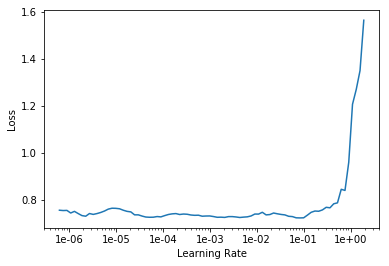

In [46]:
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(3, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.609902,0.756067,0.679035


In [48]:
learn.save('first')

In [49]:
learn.load('first');

In [50]:
### 2 

In [51]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.637171,0.629119,0.677180


In [52]:
learn.save('second')

In [53]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (4848 items)
[Category Not the A-hole, Category Asshole, Category Asshole, Category Asshole, Category Not the A-hole]...
Path: …
x: TextList (4848 items)
[Text xxbos xxup wibta for asking my gay little brother not to bring home guys to the apartment while he is living with me ? “ xxmaj ryan ” is 15 and came out to our homophobic parents about four months ago . xxmaj they promptly kicked him out of the house and he had to come live with me . i ’ve also lost contact with my parents because of this . 

 xxmaj for the most part living with him has been fine . xxmaj he picks up after himself ( mostly ) and still goes to school and works to help me out with bills . 

 xxmaj one thing however , is that lately he has been seeing this boy and bringing him over to the apartment to have sex ( i have a spare bedroom ) . 

 i do n’t care if he ’s having sex or who it ’s with , and i mean i really could not care less i ca n’t empha

In [54]:
### 3 

In [55]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.638839,0.598738,0.688312


In [57]:
learn.save('third')

In [58]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList
y: CategoryList (4848 items)
[Category Not the A-hole, Category Asshole, Category Asshole, Category Asshole, Category Not the A-hole]...
Path: …
x: TextList (4848 items)
[Text xxbos xxup wibta for asking my gay little brother not to bring home guys to the apartment while he is living with me ? “ xxmaj ryan ” is 15 and came out to our homophobic parents about four months ago . xxmaj they promptly kicked him out of the house and he had to come live with me . i ’ve also lost contact with my parents because of this . 

 xxmaj for the most part living with him has been fine . xxmaj he picks up after himself ( mostly ) and still goes to school and works to help me out with bills . 

 xxmaj one thing however , is that lately he has been seeing this boy and bringing him over to the apartment to have sex ( i have a spare bedroom ) . 

 i do n’t care if he ’s having sex or who it ’s with , and i mean i really could not care less i ca n’t empha

In [59]:
### last 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.544968,0.605008,0.682746


In [ ]:
learn.save('last')

## Results

In [59]:
from fastai.metrics import error_rate
from fastai.vision import *

In [60]:
interp = ClassificationInterpretation.from_learner(learn_clas)


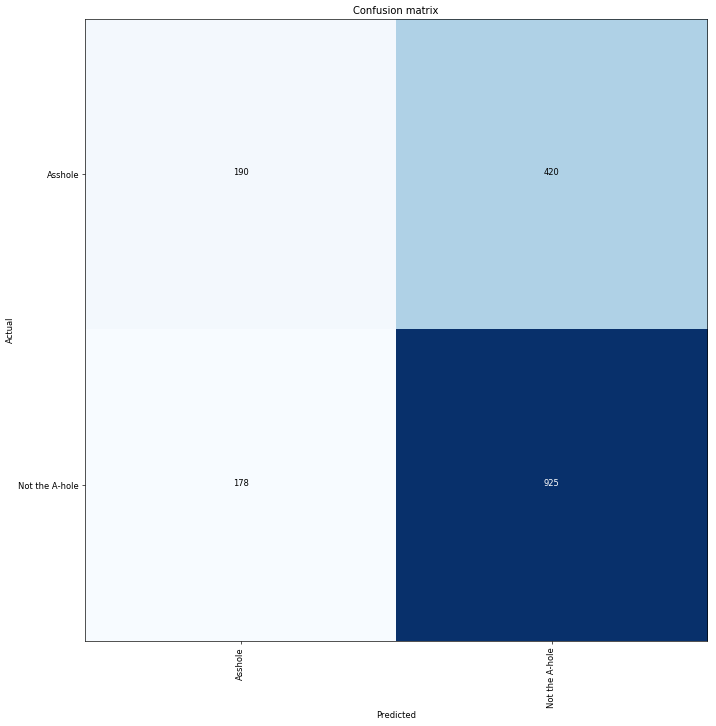

In [61]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [ ]:
# Get predictions as numpy 
valid_set = pd.concat([y_test,X_test],axis=1, sort=False)
preds = learn.get_preds()
y_score = preds[0][:,1].numpy()
y_test = valid_set.label.values

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# plot stuff
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()